In [1]:
%matplotlib inline
from __future__ import print_function, division, absolute_import
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from matplotlib.ticker import FormatStrFormatter
from pyuvwsim import evaluate_baseline_uvw_ha_dec
from math import radians, degrees, pi

In [2]:
# Load CASA VLA-C XYZ (ECEF) coordinates.
coords = np.loadtxt('../models/vla.c.cfg')
x, y, z = coords[:, 0], coords[:, 1], coords[:, 2]

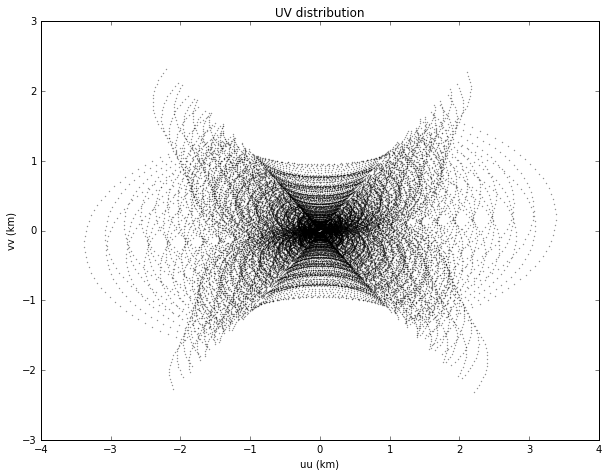

In [84]:
# Generate UV coordinates
lat = radians(34 + 4.0/60.0 + 43.497 / 3600.0)  # http://www.vla.nrao.edu/genpub/overview/
lon = -radians(107 + 37 / 60 + 3.819 / 3600.0)
dec = radians(-30.0)
ha_min = -4
ha_max = +4
num_times = ((ha_max - ha_min) * 60) // 10  # 1 sample every 10 min

uu, vv, ww = list(), list(), list()
for i, ha in enumerate(np.linspace((ha_min/24)*(2*pi), (ha_max/24)*(2*pi), num_times)):
    # print(i, degrees(ha), degrees(dec), degrees(ha - lon))
    uu_, vv_, ww_ = evaluate_baseline_uvw_ha_dec(x, y, z, ha - lon, dec)
    uu, vv, ww = np.append(uu, uu_), np.append(vv, vv_), np.append(ww, ww_)

fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, aspect='equal')
ax.plot(uu / 1.0e3, vv / 1.0e3, '.', color='k', ms=2.0, alpha=0.3)
ax.plot(-uu / 1.0e3, -vv / 1.0e3, '.', color='k', ms=2.0, alpha=0.3)
ax.set_xlabel('uu (km)')
ax.set_ylabel('vv (km)')
ax.set_title('UV distribution')
plt.show()

In [76]:
# Convert to r, theta
uu_ = np.copy(uu)
vv_ = np.copy(vv)
r = (uu_**2 + vv_**2)**0.5
theta = np.arctan2(vv_, uu_)
theta[theta < 0.0] += pi
# fig = plt.figure(figsize=(5, 5))
# ax = fig.add_subplot(111, polar=True)
# ax.plot(theta, r / 1.0e3, 'k.', ms=2.0, alpha=0.1)
# ax.plot(theta - pi, r / 1.0e3, 'r.', ms=2.0, alpha=0.05)
# plt.show()

In [72]:
num_bins = 20
r_max = r.max()
theta_edges = np.linspace(0, pi, num_bins + 1)
r_edges = np.linspace(0, r_max, num_bins + 1)
theta_idx = np.digitize(theta, theta_edges)

uv_gap_im = np.zeros((num_bins, num_bins))
uv_gap_im_2 = np.zeros((num_bins, num_bins))

# Loop over theta bins
for j in range(num_bins):
    r_values = r[theta_idx == 1 + j]
    r_values = np.append(r_values, 0.0)
    t_values = theta[theta_idx == 1 + j]
    t_values = np.append(t_values, 0.0)
    order = np.argsort(r_values)
    r_values = r_values[order]
    t_values = t_values[order]
    r_diff = np.diff(r_values)
    r_diff_norm = r_diff / r_values[1:]
    
    # Loop over r bins (within the theta bin)
    for i in range(num_bins):
        d0 = np.where(r_values <= r_edges[i])[0][-1]
        d1 = np.where(r_values > r_edges[i + 1])[0]
        d1 = r_values.shape[0] - 1 if len(d1) == 0 else d1[0]
        bin_diffs = r_diff_norm[d0:d1]
        uv_gap_im[j, i] = numpy.nanmean(bin_diffs) if bin_diffs.shape[0] > 0 else 1.0

        rmax_ = r_edges[i + 1]
        x_b = np.append(r_values, rmax_)
        x_b = np.sort(x_b)
        x_b = x_b[x_b < rmax_]
        uv_gap_im_2[j, i] = np.sum(np.diff(x_b)**2 / x_b[1:]) / rmax_
    
# fig = plt.figure(figsize=(12, 5))
# ax = fig.add_subplot(121)
# image = np.transpose(uv_gap_im)
# extent = [theta_edges[0], theta_edges[-1],
#           r_edges[0]/1.0e3, r_edges[-1]/1.0e3]
# im = ax.imshow(image, interpolation='nearest', 
#                origin='lower', cmap='jet', extent=extent, 
#                norm=LogNorm(vmax=0.225))
# ax.figure.colorbar(im, ax=ax)
# ax.set_xlabel('theta')
# ax.set_ylabel('r (km)')

# ax = fig.add_subplot(122)
# image = np.transpose(uv_gap_im)
# extent = [theta_edges[0], theta_edges[-1],
#           r_edges[0]/1.0e3, r_edges[-1]/1.0e3]
# im = ax.imshow(image, interpolation='nearest', 
#                origin='lower', cmap='jet', extent=extent)
# ax.figure.colorbar(im, ax=ax)
# ax.set_xlabel('theta')
# ax.set_ylabel('r (km)')
# plt.show()

# fig = plt.figure(figsize=(5, 5))
# ax = fig.add_subplot(111)
# image = np.transpose(uv_gap_im_2)
# extent = [theta_edges[0], theta_edges[-1],
#           r_edges[0]/1.0e3, r_edges[-1]/1.0e3]
# im = ax.imshow(image, interpolation='nearest', 
#                origin='lower', cmap='jet', extent=extent)
# ax.figure.colorbar(im, ax=ax)
# ax.set_xlabel('theta')
# ax.set_ylabel('r (km)')
# plt.show()

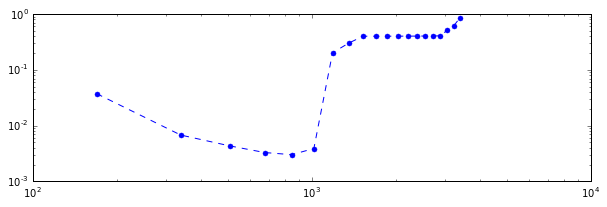

In [70]:
# Convert to radial profile
uv_gap_r = np.zeros(num_bins)
for i in range(num_bins):
    uv_gap_r[i] = np.mean(uv_gap_im[:, i])
    
fig = plt.figure(figsize=(10, 3))
ax = fig.add_subplot(111)
ax.plot(r_edges[1:], uv_gap_r, '.--', ms=10.0)
ax.set_xscale('log')
ax.set_yscale('log')
plt.show()

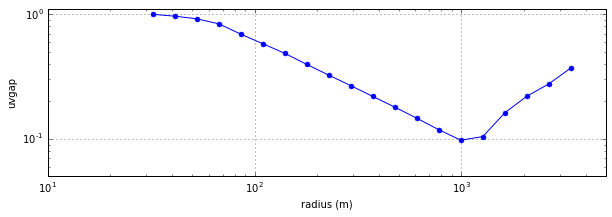

In [29]:
# Results from iAntConfig (http://public.ska.ac.za/software/iantconfig)
data = np.loadtxt('/Users/bmort/Desktop/ant_conf_metrics.txt.20x3.txt')
fig = plt.figure(figsize=(10, 3))
ax = fig.add_subplot(111)
ax.plot(data[:, 1], data[:, 3], '.-', ms=10)
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_ylim(0.05, 1.1)
ax.set_xlim(10, 5000)
ax.grid(True)
ax.set_xlabel('radius (m)')
ax.set_ylabel('uvgap')
plt.show()

In [91]:
print(data[:5, 1])
print(data[-1, 1])
r3d = (uu**2 + vv**2 + ww**2)**0.5
print(r.max(), r3d.max())
e__ = np.logspace(np.log10(1), np.log10(data[-1, 1]), num_bins + 1)
print(e__[-5:])

[ 32.24903107  41.20064545  52.63702774  67.24789429  85.91441345]
3387.475586
3387.19823522 3387.46861997
[  666.6546905   1000.90935359  1502.75629706  2256.22478224  3387.475586  ]


In [92]:
# Bin centres?
c__ = np.logspace(np.log10(data[0, 1]), np.log10(data[-1, 1]), num_bins)
print(c__[-5:])

[ 1271.53056673  1624.47917041  2075.39845612  2651.4829061   3387.475586  ]
